In [1]:
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
sample_num = 10000
feature_size = 100
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
task_num = 3
alph = 0.16

In [3]:
def generate_data(N = 10000, M = 100, c = 0.5, task_num = 3):
    X = np.random.normal(0, 1, (N, M))
    Y = []
    for i in range(task_num):
        p = np.random.rand()
        k = np.random.randn(M)
        u1 = np.random.randn(M)
        u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
        u1 /= np.linalg.norm(u1) 
        k /= np.linalg.norm(k) 
        u2 = k
        w = c*(p*u1+np.sqrt((1-p**2))*u2)
        eps = np.random.normal(0, 0.01)
        temp =  np.matmul(X, w) + np.sin(np.matmul(X, w))+eps
        Y.append(temp)
        print("task ", i)
        plt.plot(X,temp)
        plt.show() 
    return X, np.array(Y).transpose()

def split_data(X, Y):
    sample_num = X.shape[0]
    split = list(np.random.permutation(sample_num))
    return X[split[:int(sample_num * 0.8)],:], Y[split[:int(sample_num * 0.8)],:], X[split[int(sample_num * 0.8): int(sample_num * 0.9)],:], Y[split[int(sample_num * 0.8): int(sample_num * 0.9)],:], X[split[int(sample_num * 0.9):],:], Y[split[int(sample_num * 0.9):],:]

class TrainSet(Dataset):
    def __init__(self, data, label):
        self.data, self.label = data.float(), label.float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

task  0


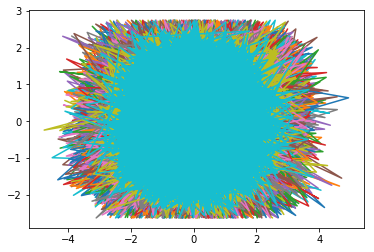

task  1


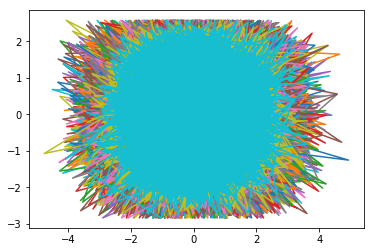

task  2


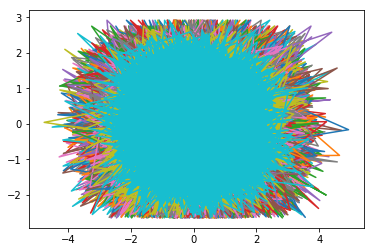

In [4]:
class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower = nn.ModuleList([nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        ) for i in range(task_num)])

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out = []
        for i in range(task_num):
            net = self.tower[i]
            out.append(net(h_shared))
        return out


def del_tensor_ele(arr,index):
    l = []
    for i in range(len(arr)):
        if i != index:
            l.append(arr[i][0].view(-1))
    return torch.stack((l))
X, Y = generate_data(N = sample_num, M = feature_size, task_num = task_num)
X, Y = torch.Tensor(X).cuda(), torch.Tensor(Y).cuda()
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X,Y)
trainset = TrainSet(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=mb_size, shuffle=True)

Iter-0; MTL loss: 0.8795
Iter-1; MTL loss: 0.4098
Iter-2; MTL loss: 0.3442
Iter-3; MTL loss: 0.271
Iter-4; MTL loss: 0.2988
Iter-5; MTL loss: 0.2614
Iter-6; MTL loss: 0.2585
Iter-7; MTL loss: 0.2144
Iter-8; MTL loss: 0.2114
Iter-9; MTL loss: 0.2183
Iter-10; MTL loss: 0.2162
Iter-11; MTL loss: 0.1933
Iter-12; MTL loss: 0.2225
Iter-13; MTL loss: 0.1961
Iter-14; MTL loss: 0.1831
Iter-15; MTL loss: 0.1607
Iter-16; MTL loss: 0.1926
Iter-17; MTL loss: 0.1798
Iter-18; MTL loss: 0.2568
Iter-19; MTL loss: 0.166
Iter-20; MTL loss: 0.2331
Iter-21; MTL loss: 0.1642
Iter-22; MTL loss: 0.1882
Iter-23; MTL loss: 0.174
Iter-24; MTL loss: 0.1675
Iter-25; MTL loss: 0.1584
Iter-26; MTL loss: 0.1906
Iter-27; MTL loss: 0.2005
Iter-28; MTL loss: 0.1727
Iter-29; MTL loss: 0.2071
Iter-30; MTL loss: 0.228
Iter-31; MTL loss: 0.2074
Iter-32; MTL loss: 0.181
Iter-33; MTL loss: 0.1702
Iter-34; MTL loss: 0.1794
Iter-35; MTL loss: 0.2118
Iter-36; MTL loss: 0.1733
Iter-37; MTL loss: 0.196
Iter-38; MTL loss: 0.1557
It

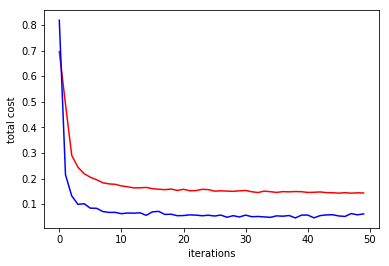

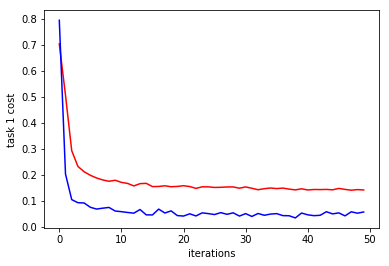

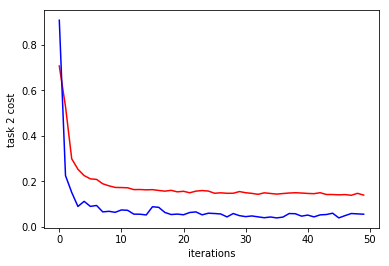

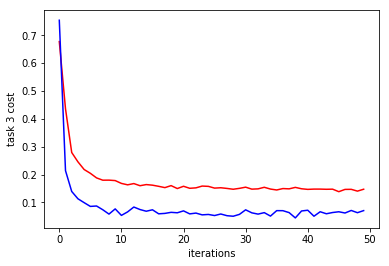

In [5]:
MTL = MTLnet().cuda()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
loss_func = nn.MSELoss()
num_minibatches = int(sample_num / mb_size) 
costtr2 = []
costD2 = []
costts2 = []
costLD2 = []
for it in range(epoch):
    epoch_cost = np.zeros([task_num + 1])
    coef = 0
    for XE, YE in trainloader:
        MTL.train()
        Yhat = MTL(XE)
        l = []
        for i, yhat in enumerate(Yhat):
            l.append(loss_func(yhat, YE[:, i].view(-1,1)))
        l = torch.stack(l)
        loss = torch.mean(l)
        opt1.zero_grad()
        loss.backward(retain_graph=True)   

        opt1.step()

        epoch_cost[0] = epoch_cost[0] + (loss / num_minibatches)
        for i in range(1,task_num+1):
            epoch_cost[i] = epoch_cost[i] + (l[i - 1] / num_minibatches)
    costtr2.append(epoch_cost)
    
    with torch.no_grad():
        MTL.eval()
        YhatD = MTL(X_val)
        lD = []
        for i, yhatd in enumerate(YhatD):
            lD.append(loss_func(yhatd, Y_val[:, i].view(-1,1)))
        lD = torch.stack(lD)
        costLD2.append(lD)
        cur_task = lD.argmax()
        costD2.append(torch.mean(lD))
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))

costLD2 = torch.stack(costLD2).cpu().numpy()
costtr2 = np.array(costtr2)
plt.plot(np.squeeze(costtr2[:, 0]),'-r',np.squeeze(costD2), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

for i in range(task_num):
    plt.plot(np.squeeze(costtr2[:, i + 1]),'-r', np.squeeze(costLD2[:, i]), '-b')
    plt.ylabel('task {0} cost'.format(i + 1))
    plt.xlabel('iterations')
    plt.show() 

/data/xuejiabin/workspace/pix2pix/pytorch-CycleGAN-and-pix2pix/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/data/xuejiabin/workspace/pix2pix/pytorch-CycleGAN-and-pix2pix/venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter-0; MTL loss: 0.6461
Iter-1; MTL loss: 0.3962
Iter-2; MTL loss: 0.2246
Iter-3; MTL loss: 0.2232
Iter-4; MTL loss: 0.1975
Iter-5; MTL loss: 0.1808
Iter-6; MTL loss: 0.1603
Iter-7; MTL loss: 0.1685
Iter-8; MTL loss: 0.1329
Iter-9; MTL loss: 0.1485
Iter-10; MTL loss: 0.1765
Iter-11; MTL loss: 0.1649
Iter-12; MTL loss: 0.1617
Iter-13; MTL loss: 0.1351
Iter-14; MTL loss: 0.1418
Iter-15; MTL loss: 0.1337
Iter-16; MTL loss: 0.1735
Iter-17; MTL loss: 0.1384
Iter-18; MTL loss: 0.1456
Iter-19; MTL loss: 0.1243
Iter-20; MTL loss: 0.1222
Iter-21; MTL loss: 0.1338
Iter-22; MTL loss: 0.127
Iter-23; MTL loss: 0.1121
Iter-24; MTL loss: 0.1139
Iter-25; MTL loss: 0.1034
Iter-26; MTL loss: 0.114
Iter-27; MTL loss: 0.1165
Iter-28; MTL loss: 0.1052
Iter-29; MTL loss: 0.1134
Iter-30; MTL loss: 0.1659
Iter-31; MTL loss: 0.1436
Iter-32; MTL loss: 0.1331
Iter-33; MTL loss: 0.1121
Iter-34; MTL loss: 0.09781
Iter-35; MTL loss: 0.1265
Iter-36; MTL loss: 0.1255
Iter-37; MTL loss: 0.1214
Iter-38; MTL loss: 0.11

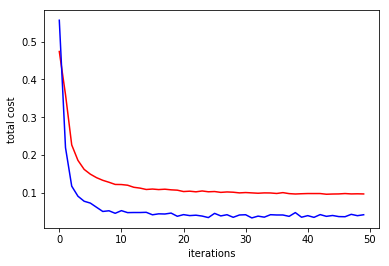

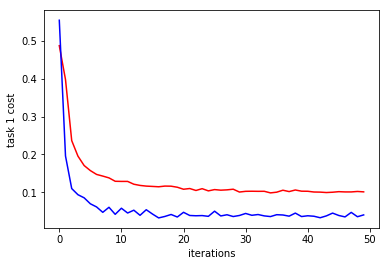

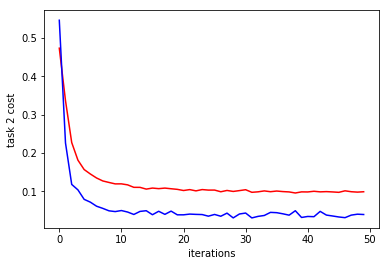

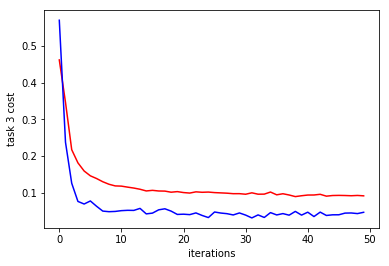

In [6]:
Weightloss = torch.tensor(torch.FloatTensor(np.ones([task_num])))
Weightloss = Weightloss.cuda()
Weightloss.requires_grad = True
MTL = MTLnet().cuda()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam([Weightloss], lr=LR)
loss_func = nn.MSELoss()
Gradloss = nn.L1Loss()
cur_task = 0
num_minibatches = int(sample_num / mb_size)
costtr5 = []
costD5 = []
costts5 = []
costLD5 = []
for it in range(epoch):
    epoch_cost = np.zeros([task_num + 1])
    coef = 0
    for XE, YE in trainloader:
        MTL.train()
        Yhat = MTL(XE)
        l = []
        for i, yhat in enumerate(Yhat):
            l.append(Weightloss[i] * loss_func(yhat, YE[:, i].view(-1,1)))
        l = torch.stack(l)
        loss = torch.mean(l)

        if it == 0:
            L = torch.tensor(l).data

        opt1.zero_grad()

        loss.backward(retain_graph=True)   

        param = list(MTL.parameters())
        G = []
        GR = []
        C = []
        for i in range(task_num):
            gr = torch.autograd.grad(l[i], param[0], retain_graph=True, create_graph=True)
            GR.append(gr)
            G.append(torch.norm(gr[0], 2))
        lhat = torch.div(l,L)
        lhat_avg = torch.mean(lhat)
        inv_rate = torch.div(lhat,lhat_avg)
        G_avg = torch.mean(torch.stack(G))
        C = torch.mul(G_avg, (inv_rate**alph))
        C = C.detach()

        opt2.zero_grad()
        Lgrad = Gradloss(torch.tensor(G, requires_grad=True).cuda(), C).sum()
        Lgrad.backward()

        opt2.step()

        
        grad_cur  = GR[cur_task][0].view(-1)
        grad_rep  = torch.mean(del_tensor_ele(GR, cur_task), dim=0)
        angle = (grad_cur*grad_rep).sum()
        if angle < 0:
            length_rep = (grad_rep*grad_rep).sum()
            grad_proj = grad_cur-(angle/length_rep)*grad_rep
            p = param[0]
            n_param = p.numel()
            p.grad.copy_(grad_proj.view_as(p))
        opt1.step()

        coef = 2/Weightloss.sum()
        Weightloss = torch.mul(coef, Weightloss)
        epoch_cost[0] = epoch_cost[0] + (loss / num_minibatches)
        for i in range(1,task_num+1):
            epoch_cost[i] = epoch_cost[i] + (l[i - 1] / num_minibatches)
        with torch.no_grad():
            MTL.eval()
            YhatD = MTL(X_val)
            lD = []
            for i, yhatd in enumerate(YhatD):
                lD.append(Weightloss[i] * loss_func(yhatd, Y_val[:, i].view(-1,1)))
            lD = torch.stack(lD)
            cur_task = lD.argmax()
    costtr5.append(epoch_cost)
    
    with torch.no_grad():
        MTL.eval()
        YhatD = MTL(X_val)
        lD = []
        for i, yhatd in enumerate(YhatD):
            lD.append(Weightloss[i] * loss_func(yhatd, Y_val[:, i].view(-1,1)))
        lD = torch.stack(lD)
        costLD5.append(lD)
        cur_task = lD.argmax()
        costD5.append(torch.mean(lD))
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))

costLD5 = torch.stack(costLD5).cpu().numpy()
costtr5 = np.array(costtr5)
plt.plot(np.squeeze(costtr5[:, 0]),'-r',np.squeeze(costD5), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

for i in range(task_num):
    plt.plot(np.squeeze(costtr5[:, i + 1]),'-r', np.squeeze(costLD5[:, i]), '-b')
    plt.ylabel('task {0} cost'.format(i + 1))
    plt.xlabel('iterations')
    plt.show() 

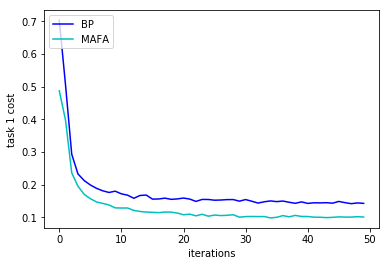

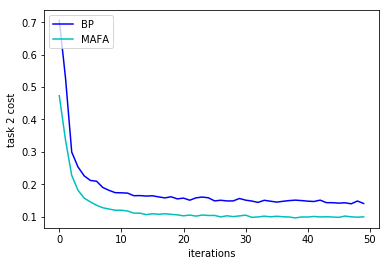

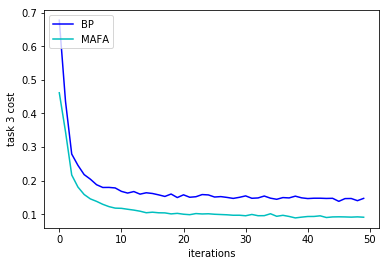

In [7]:
for i in range(task_num):
    plt.plot(np.squeeze(costtr2[:, i + 1]), '-b', np.squeeze(costtr5[:, i + 1]), '-c')
    plt.ylabel('task {0} cost'.format(i + 1))
    plt.xlabel('iterations')
    label = ['BP', 'MAFA']
    plt.legend(label, loc='upper left')
    plt.show()

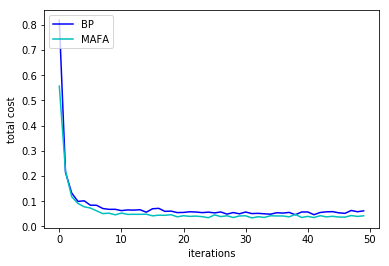

In [8]:
plt.plot(np.squeeze(costD2),'-b', np.squeeze(costD5),'-c')
plt.ylabel('total cost')
plt.xlabel('iterations')
label = ['BP', 'MAFA']
plt.legend(label, loc='upper left')
plt.show() 